In [1]:
import sys
sys.path.append('../..')
import ugent
import numpy as np
from math import pi

In [2]:
def T(alpha, t):
    cy = 1/np.sin(alpha)
    # beta = asin(t * sin(pi/2 - alpha))
    beta = t * alpha
    r = 1/np.tan(alpha)
    return (r*np.sin(beta), cy - r*np.cos(beta))

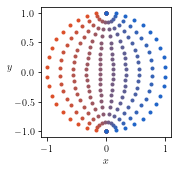

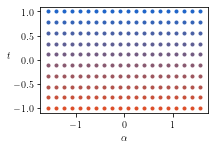

In [36]:
import matplotlib.pyplot as plt
import string
import numpy as np
import matplotlib as mpl

mpl.rc('font', family='serif', size=10, serif="Computer Modern Roman")
mpl.rc('text', usetex=True)

alphas = np.linspace(float(-pi/2), float(pi/2), 20)
ts = np.linspace(-1, 1, 10)

base = 0.6
f1, ax1 = plt.subplots(figsize=(5*base,4*base))
f2, ax2 = plt.subplots(figsize=(5*base,4*base))

ax1.set_aspect(1)
ax2.set_aspect(1)

for i, t in enumerate(ts):
    c = ugent.mix(ugent.rood, ugent.blauw, i/(len(ts)-1))
    ax1.plot(*zip(*(T(alpha, t) for alpha in alphas)), '.', color=c)
    ax2.plot(*zip(*((alpha, t) for alpha in alphas)), '.', color=c)

ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$', rotation=0)

ax2.set_xlabel('$\\alpha$')
ax2.set_ylabel('$t$', rotation=0)

f1.savefig("disc_transformed.pdf", bbox_inches="tight")
f2.savefig("disc_original.pdf", bbox_inches="tight")

In [13]:
var('alpha, t')
sT = vector(SR, T(alpha,t))
sTa = diff(sT, alpha)
sTt = diff(sT, t)
sTaa = diff(sTa, alpha)
sTat = diff(sTa, t)
sTtt = diff(sTt, t)

ua, va = sTa
ut, vt = sTt
uaa, vaa = sTaa
uat, vat = sTat
utt, vtt = sTtt

cs = (matrix([
        [ua, va, 0, 0, 0],
        [ut, vt, 0, 0, 0],
        [uaa, vaa, ua*ua, 2*ua*va, va*va],
        [uat, vat, ua*ut, (ut*va+ua*vt), va*vt],
        [utt, vtt, ut*ut, 2*ut*vt, vt*vt]
]).solve_left(vector([0,0,1,0,1]))).simplify_full()

cs = [fast_callable(c, vars=(alpha, t), domain=float) for c in cs]

NameError: name 'var' is not defined

In [5]:
import numpy as np
import scipy.linalg as scl
import scipy.sparse as scs
import scipy.sparse.linalg as scsl

na = 61
nt = 61

assert na%2 == 1

alphas = np.linspace(float(-pi/2), float(pi/2), na+1)
ha = float(alphas[1] - alphas[0])

indices = [(int(i), int(j)) for j in range(1, nt) for i in range(1, na)]

def tridiag(abc, n):
    a, b, c = abc
    return matrix.toeplitz([b, a] + [0]*(n-2), [c] + [0]*(n-2), ring=RDF).numpy(dtype="float")

def D1(n):
    return tridiag((-1, 0, 1), n)

def D2(n):
    return tridiag((1, -2, 1), n)

def I(n):
    return np.eye(n, dtype="float")

def k(A, B):
    return np.kron(A, B)

Ma = k(I(nt-1), D1(na-1))/float(2*ha)
Mt = k(D1(nt-1), I(na-1))/float(2)
Maa = k(I(nt-1), D2(na-1))/float(ha*ha)
Mat = k(I(nt-1), D1(na-1)) @ k(D1(nt-1), I(na-1))/float(4*ha)
Mtt = k(D2(nt-1), I(na-1))

def matrix_problem(epsilon):
    ts = np.linspace(-1, float(2*epsilon-1), nt+1)
    ht = float(ts[1] - ts[0])

    def C(k):
        v = np.ndarray((len(indices),), dtype="float")
        for l, (i, j) in enumerate(indices):
            v[l] = cs[k](alphas[i], ts[j])
        return v
    
    M = scs.dia_matrix(np.multiply(C(4)[:,None], Mtt))
    M /= ht
    M += np.multiply(C(1)[:,None], Mt)
    M += np.multiply(C(3)[:,None], Mat)
    M /= ht
    M += np.multiply(C(0)[:,None], Ma)
    M += np.multiply(C(2)[:,None], Maa)
    M *= -1
    
    return M

def band_eigenvalues(M, n, **kwargs):
    # M should be symmetric
    B = np.zeros((n, M.shape[0]), dtype="float")
    for i in range(n):
        B[-1-i, i:] = np.diagonal(M, i)
    return scl.eigvals_banded(B, **kwargs)
    

/opt/sage/local/lib/python3.7/site-packages/scipy/linalg/__init__.py:212: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/opt/sage/local/lib/python3.7/site-packages/scipy/sparse/sputils.py:23: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/opt/sage/local/lib/python3.7/site-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-n

In [6]:
def solve_problem(epsilon):
    M = matrix_problem(epsilon)
    return sorted(np.real(scsl.eigs(scs.dia_matrix(M), k = 20, sigma=float(0), return_eigenvectors=False)))

In [7]:
from pqdm.processes import pqdm

epsilons = np.linspace(0.01, 1, 200)
solutions = pqdm(epsilons, solve_problem, n_jobs=12)

QUEUEING TASKS | :   0%|          | 0/200 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/200 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/200 [00:00<?, ?it/s]

In [8]:
from scipy import special as sc

exact = []
for i in range(100):
    zeros = sc.jn_zeros(i, 10)
    zeros **= 2
    if zeros[0] > 100:
        break
    assert zeros[-1] > 100
    for z in zeros:
        if z > 100:
            break
        exact.append((z, 1 if i == 0 else 2))
exact.sort()

/opt/sage/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/sage/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/sage/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


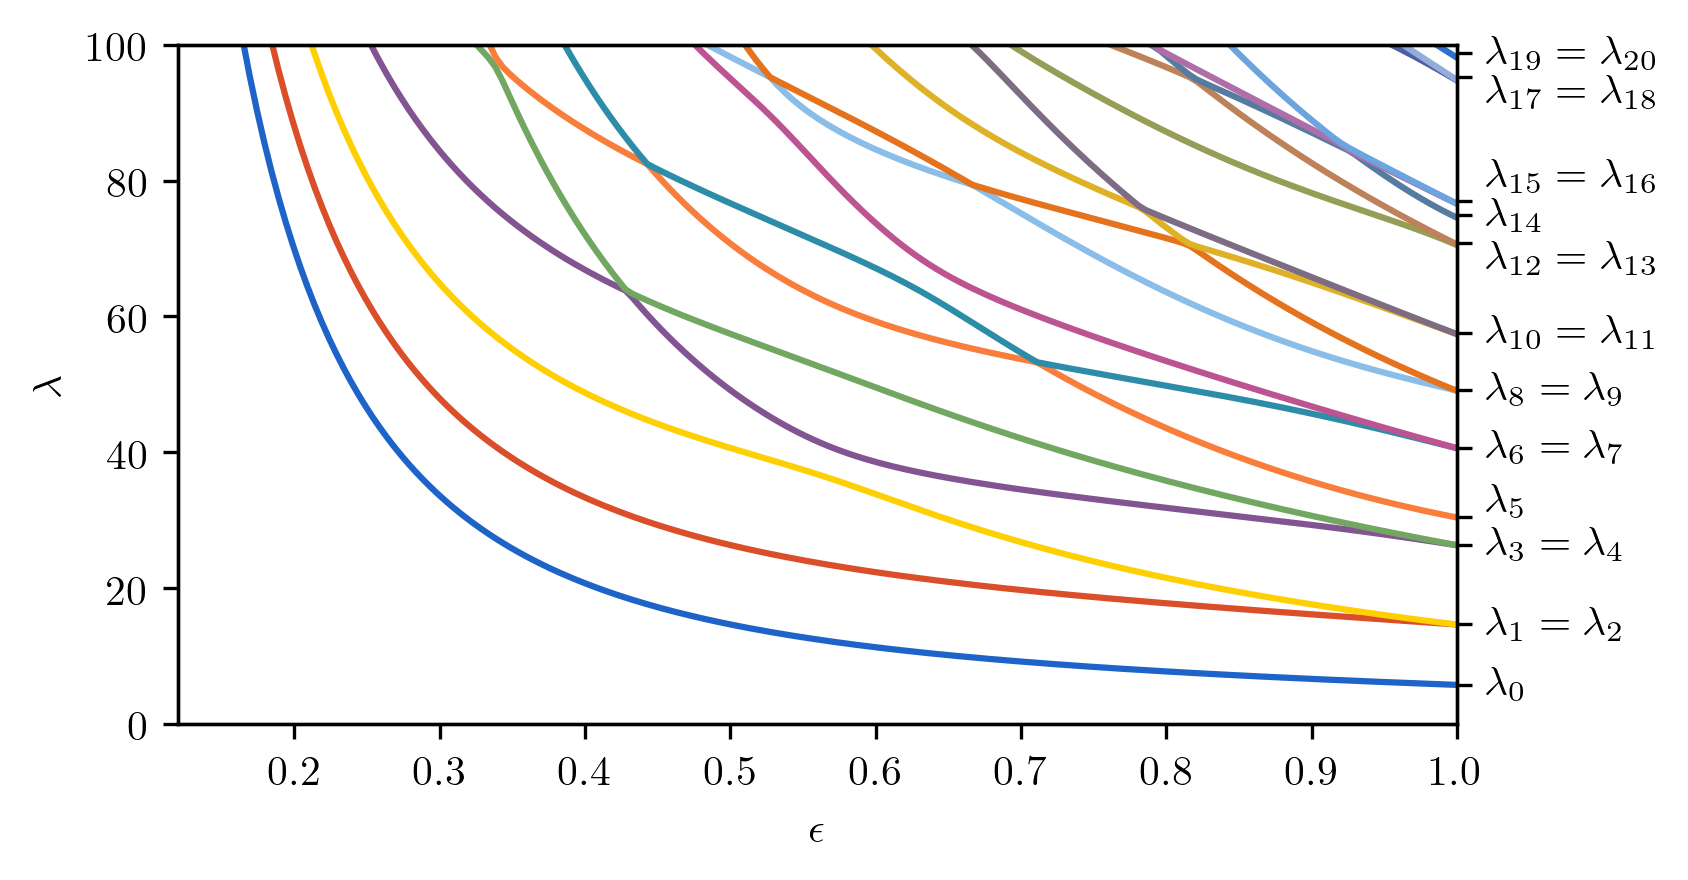

In [9]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(5.5,3), dpi=300)
for kleur, (i, v) in zip(ugent.palet, enumerate(list(zip(*solutions)))):
    plt.plot(epsilons, v, color=kleur)
plt.ylim(0,100)
plt.xlim(0.12, 1)

ax2 = ax1.twinx()
ax2.set_ylim(ax1.get_ylim())

ticks = []
labels = []

k = 0
for e, m in exact:
    ticks.append(e)
    labels.append(f"$\\lambda_{{{k}}}$"  if m == 1 else f"$\\lambda_{{{k}}} = \\lambda_{{{k+1}}}$")
    k += m
    
ax2.set_yticks(ticks)
ax2.set_yticklabels(labels)
ax2.get_yticklabels()[3].set_verticalalignment("baseline")
ax2.get_yticklabels()[7].set_verticalalignment("top")
ax2.get_yticklabels()[9].set_verticalalignment("bottom")
ax2.get_yticklabels()[10].set_verticalalignment("top")

ax1.set_xlabel("$\\epsilon$")
ax1.set_ylabel("$\\lambda$")
# plt.savefig("eigenvalues_flow.pdf", bbox_inches="tight")

None

In [10]:
exact

[(5.783185962946785, 1),
 (14.681970642123895, 2),
 (26.374616427163392, 2),
 (30.471262343662087, 1),
 (40.70646581820033, 2),
 (49.2184563216946, 2),
 (57.58294090329111, 2),
 (70.84999891909585, 2),
 (74.88700679069518, 1),
 (76.9389283336474, 2),
 (95.27757254403716, 2),
 (98.72627247724938, 2)]

In [17]:
def eigenfunction(E, eps=1):
    ts = np.linspace(-1, float(2*eps-1), nt+1)

    M = matrix_problem(eps)
    E, v = scsl.eigs(M, k=1, sigma=float(E))
    return E[0], np.real(v[:,0])

In [18]:
%%time

import scipy.sparse.linalg as scsl
import scipy.optimize as sco

E = 45
tofind = sum(1 for e in solutions[-1] if e < E)
print(tofind)

def find_domain(i):
    j = 0
    while solutions[j][i] > E:
        j += 1
        
    low = epsilons[j-1]
    high = epsilons[j]
    
    def f(eps):
        M = matrix_problem(eps)
        return E - np.real(scsl.eigs(M, k=1, sigma=float(E), return_eigenvectors=False)[0])
        
    return sco.root_scalar(f, x0=low, x1=high).root

domains = pqdm(range(tofind), find_domain, n_jobs=10)
eigenfunctions = []

for eps in domains:
    Ecorrected, eigvec = eigenfunction(E, eps)
    assert abs(Ecorrected - E) < 1e-2
    print(Ecorrected)
    ts = np.linspace(-1, float(2*eps-1), nt+1)

    Z = np.zeros((na+1, nt+1))
    Z[1:-1,1:-1] = eigvec.reshape((na-1, nt-1))
    
    X, Y = T(np.tile(alphas, (len(ts), 1)), np.tile(ts, (len(alphas), 1)).T)
    eigenfunctions.append((Ecorrected, eps, (X, Y, Z)))

8


QUEUEING TASKS | :   0%|          | 0/8 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/8 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/8 [00:00<?, ?it/s]

(45.00000002359354+0j)
(44.99999999955147+0j)
(44.99999994686754+0j)
(44.9999999664274+0j)
(44.99999999827497+0j)
(45.00000078441715+0j)
(45.000000000912195+0j)
(44.999999865955076+0j)
CPU times: user 7.42 s, sys: 544 ms, total: 7.96 s
Wall time: 21.1 s


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for row in axs:
    for ax in row:
        ax.axis('off')
        ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator())
        ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator())
    
for plot_i, (E, eps, (X, Y, Z)) in enumerate(eigenfunctions):
    print(plot_i, eps)
    ts = np.linspace(-1, float(2*eps-1), nt+1)
    
    m = np.max(np.abs(Z))
    ax = axs[plot_i // 5, plot_i%5]
    ax.set_aspect(1)
    moon = patches.Polygon([
        tuple(map(float, T(alpha, t))) for alpha, t in (
        [(0,1)]
        + [(alpha, ts[0]) for alpha in alphas]
        + [(3.1415,1)]
        + [(alpha, ts[-1]) for alpha in alphas[::-1]]
        + [(0,1)])
    ], facecolor="none")
    ax.add_patch(patches.Circle((0,0), 1.01, facecolor="lightgray", edgecolor="gray", linewidth=1, zorder=0))
    ax.add_patch(moon)
    ax.pcolormesh(X, Y, Z, shading='gouraud', vmin=-m, vmax=m, cmap=ugent.RdBu, clip_on=True, clip_path=moon, zorder=5)

plt.tight_layout()
# plt.savefig("../img/disc.pdf", bbox_inches="tight")

In [ ]:
alphas[::-1]

In [7]:
import matplotlib.patches as patches
import numpy as np

eps = 0.6

nt = 30
na = 30

ts = np.linspace(-1, float(2*eps-1), nt+1)
alphas = np.linspace(0, float(2*pi), nt+1)
    
patches.Polygon([
        tuple(map(float, T(alpha, t))) for alpha, t in (
        [(0,1)]
        + [(alpha, ts[0]) for alpha in alphas]
        + [(3.1415,1)]
        + [(alpha, ts[-1]) for alpha in alphas[::-1]]
        + [(0,1)])
    ], facecolor="none")

/opt/sage/local/lib/python3.7/site-packages/sage/repl/ipython_kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  from sage.repl.ipython_kernel.kernel import SageKernel
/opt/sage/local/lib/python3.7/site-packages/sage/repl/ipython_kernel/__main__.py:5: RuntimeWarning: divide by zero encountered in double_scalars
/opt/sage/local/lib/python3.7/site-packages/sage/repl/ipython_kernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars


In [100]:
    np.tile(alphas, (len(ts), 1)).shape

(10, 52)

In [101]:
len(ts)

10